In [ ]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import gym
import time
from collections import deque

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
# target 임베딩, input shape -> (1, 16)
def one_hot(x):
    return np.identity(16)[x:x + 1].astype(np.float32)

In [ ]:
# 환경 구성
env = gym.make('FrozenLake-v0')

# Set DQN parameters
num_episodes = 20000
learning_rate = 0.1 
dis = .99     # discount_reward
h_size = 10    # 은닉층의 shape -> input(1,16) * hidden1(16,10) -> hidden2(10,4) -> output(1,4)

deque_maxlen = 2000   # 버퍼의 최대 크기

# buffer parameters
random_sample = 10    # 버퍼가 다 찬 후 num_episodes에서 언제 random.sample을 할지 결정하는 파라미터 
num_sample = 50   #sample을 뽑는 것을 얼마나 반복할 것인지 결정하는 파라미터
num_choice = 10   # buffer에서 몇 개를 추출할 것인지 결정하는 파라미터

# Input and output size based on the Env
input_size = env.observation_space.n
output_size = env.action_space.n

# weight 1  (16, 10)
W1 = tf.Variable(tf.random.uniform([input_size, h_size], 0, 0.01), dtype=tf.float32)

# weight 2  (10, 4)
W2 = tf.Variable(tf.random.uniform([h_size, output_size], 0, 0.01), dtype=tf.float32)

# optimizer
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

69.01760339736938 seconds
Success rate: 0.04365


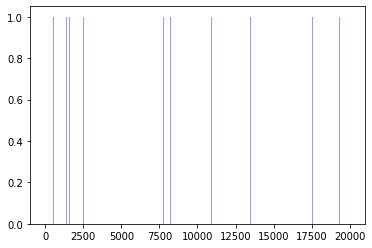

In [ ]:
start_time = time.time()
# rewards per episode
rList = []
buffer = deque(maxlen=deque_maxlen)

for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    rAll = 0
    done = False
    save_weight = []

    e = 1. / ((i / 50) + 10)
    # The Q-Table learning algorithm
    while not done:
        # Choose an action by greedly (with a chance of random action) from the Q-network
        # input(1,16) * W1(16,10) -> (1,10)
        dense_layer_1 = tf.matmul(one_hot(state), W1)
        activation_func_1 = tf.nn.relu(dense_layer_1)

        # input(1,10) * W2(10,4) -> (1,4)
        dense_layer_2 = tf.matmul(activation_func_1, W2)
        activation_func_2 = tf.nn.relu(dense_layer_2)

        q_value = np.array(activation_func_2.numpy())

        save_weight.append(W2)

        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_value)

        # Get new state and reward from environment
        state_next, reward, done, _ = env.step(action)
        buffer.append((state, action, reward, state_next, done))
        state = state_next

        # buffer 작동 구현
        # --------------------------------------------------------------------------------
        # buffer가 다 찼을 때, 이후의 random.sample 과정을 실행합니다
        if len(buffer) > deque_maxlen:
            pass
        if num_episodes % random_sample == 1:
            for _ in range(num_sample):
                sample = random.sample(buffer, num_choice)

                # sample의 개수 많큼 for문을 돌립니다
                for state, action, reward, state_next, done in sample:
                    if done:
                        q_value[0, action] = reward
                    else:
                        # input(1,16) * W1(16,10) -> (1,10)
                        next_dense_layer_1 = tf.matmul(one_hot(state_next), W1)
                        activation_func_1 = tf.nn.relu(next_dense_layer_1)

                        # input(1,10) * W2(10,4) -> (1,4)
                        next_dense_layer_2 = tf.matmul(activation_func_1, W2)
                        activation_func_2 = tf.nn.relu(next_dense_layer_2)

                        q_score_next = np.array(activation_func_2.numpy())

                        q_value[0, action] = reward + dis * np.max(q_score_next)

         # --------------------------------------------------------------------------------
               
                Qpred_dense_layer_1 = tf.matmul(one_hot(state), W1)
                Qpred_activation_1 = tf.nn.relu(Qpred_dense_layer_1)

                loss = lambda: tf.reduce_sum(input_tensor=tf.square(q_value - tf.nn.relu(tf.matmul(Qpred_activation_1, W2))))
                # optimizer, loss가 작아지는 방향으로 W 업데이트
                optimizer.minimize(loss, var_list=W2)


        rAll += reward
    # if i % 100 == 0:
    #     print(f'진행률: {round(i / num_episodes, 2) * 100}%')
    rList.append(rAll)

# 결과 출력
print(f'{(time.time() - start_time)} seconds')
print("Success rate: " + str(sum(rList) / num_episodes))
plt.bar(range(len(rList)), rList, color='b', alpha=0.4)
plt.show()


# 결론

DQN 2013은 기존에 Q-Network가 가지고 있는 연속된 데이터간의 유사성으로 인한 학습 능력 저하 문제를 데이터를 바로 학습에 사용하지않고 buffer를 통해 랜덤으로 추출하는 방법을 사용해서 해결했습니다. 

하지만 DQN 2013에서는 타겟값과 예측값이 같은 가중치 (W1, W2)를 공유해서 성능이 좋지않았습니다.